# Lab 1 

# PART A

In [452]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [453]:
# Convert translation velocities to angular velocities based on pitch of lead screw
folder_path = os.path.join('Data', 'part a')
file_names = os.listdir(folder_path)
file_names.sort()
pitch = 0.02*1000  # in mm

dataframes = {}
for fname in file_names:
    file_path = os.path.join(folder_path, fname)
    df = pd.read_csv(file_path, skiprows=8)
    key = os.path.splitext(fname)[0]  # e.g., 'V_90'
    dataframes[key] = df

for key, df in dataframes.items():
    # Remove 'V_' prefix and extract the numeric value from the key
    try:
        target_value = float(key.replace('V_', ''))
    except ValueError:
        continue  # skip if key is not a number

    # Drop rows with any NaN values
    df = df.dropna()

    # Filter rows where Enc2_ActVelo is within ±1 of target_value
    filtered_df = df[(np.abs(df.iloc[:, 4]) > target_value - 0.5) & (np.abs(df.iloc[:, 4]) < target_value + 0.5)]

    dataframes[key] = filtered_df.reset_index(drop=True)

print(dataframes['V_160'].head())

    Name  Enc1_ActPos (1)  Enc2_ActPos  Enc1_ActVelo  Enc2_ActVelo      Vsig
0    278          42.9955      43.0117    159.464799    159.519390  1.169817
1  278.5          43.0755      43.0922    159.490285    159.589895  1.151693
2    279          43.1554      43.1721    159.505033    159.599900  1.136332
3  279.5          43.2359      43.2522    159.576222    159.628476  1.128448
4    280          43.3162      43.3323    159.624973    159.655692  1.158135


In [454]:
# Sort the dataframes dictionary by keys in ascending order
dataframes = dict(sorted(dataframes.items(), key=lambda x: float(x[0].replace('V_', ''))))

In [455]:
# Add a column to each dataframe in dataframes with angular velocity
pitch = 0.02*1000
for key, df in dataframes.items():
    # Calculate angular velocity: 2*pi*(Enc2_ActVelo)/pitch
    df['Angular_Velocity'] = (2 * math.pi * df.iloc[:, 4]) / pitch
    dataframes[key] = df

print(dataframes['V_160'].iloc[:,5])

0       1.169817
1       1.151693
2       1.136332
3       1.128448
4       1.158135
          ...   
1822   -1.329035
1823   -1.275345
1824   -1.286399
1825   -1.258426
1826   -1.249427
Name: Vsig, Length: 1827, dtype: float64


In [456]:
Current_gain = 0.887
Motor_const = 0.72

for key, df in dataframes.items():
    df['Torque_Nm'] = df.iloc[:,5] * Motor_const * Current_gain


In [457]:
dataframes['V_160']['Torque_Nm']

0       0.747092
1       0.735517
2       0.725707
3       0.720672
4       0.739631
          ...   
1822   -0.848775
1823   -0.814486
1824   -0.821546
1825   -0.803681
1826   -0.797934
Name: Torque_Nm, Length: 1827, dtype: float64

In [458]:
for key, df in dataframes.items():
    if df.empty:
        continue  # skip empty DataFrames

    signal = df.iloc[:, 5]
    half_index = len(signal) // 2
    avg = signal.iloc[100:half_index-200].mean()
    print(f"{key}: Average voltage= {avg}")

    # Create mask for values within ±0.3 of avg or -avg
    mask = (
        (signal >= avg - 0.1) & (signal <= avg + 0.1)
    ) | (
        (signal >= -avg - 0.1) & (signal <= -avg + 0.1)
    )

    # Apply mask and update DataFrame
    filtered_df = df[mask].reset_index(drop=True)
    dataframes[key] = filtered_df



V_15: Average voltage= 0.47695698309341666
V_20: Average voltage= 0.5346244402680932
V_25: Average voltage= 0.5737684102466547
V_30: Average voltage= 0.599839361495313
V_35: Average voltage= 0.6356724826764784
V_40: Average voltage= 0.6685263831341588
V_45: Average voltage= 0.7007965138570944
V_50: Average voltage= 0.7287883691763761
V_60: Average voltage= 0.7814251845588249
V_70: Average voltage= 0.833051024865169
V_80: Average voltage= 0.881810184382415
V_90: Average voltage= 0.9259832690743591
V_100: Average voltage= 0.9674116427007824
V_120: Average voltage= 1.0456840909170118
V_140: Average voltage= 1.1220093750338191
V_160: Average voltage= 1.186977868034514


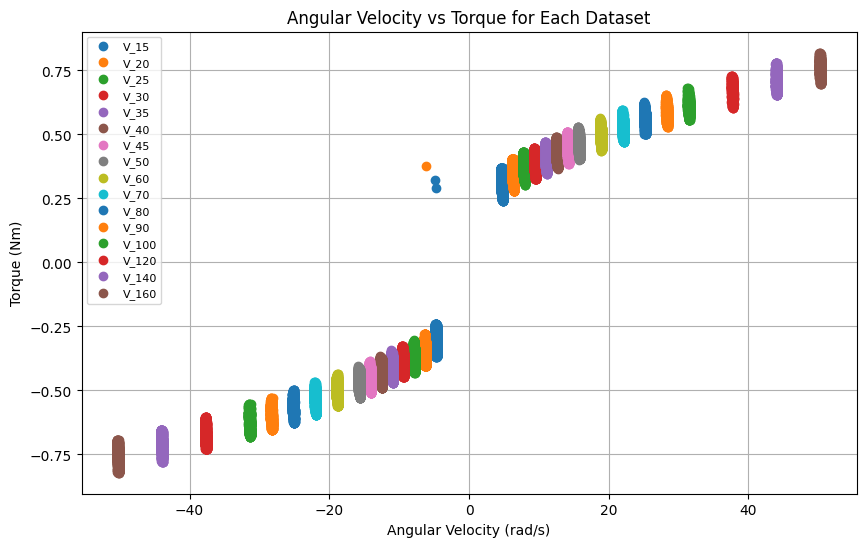

In [459]:

plt.figure(figsize=(10, 6))
for key, df in dataframes.items():
    plt.plot(df['Angular_Velocity'], df['Torque_Nm'],'o', label=key)
    
plt.xlabel('Angular Velocity (rad/s)')
plt.ylabel('Torque (Nm)')
plt.title('Angular Velocity vs Torque for Each Dataset')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


Positive fit: slope = 0.01072, intercept = 0.27630
Negative fit: slope = 0.01069, intercept = -0.28346


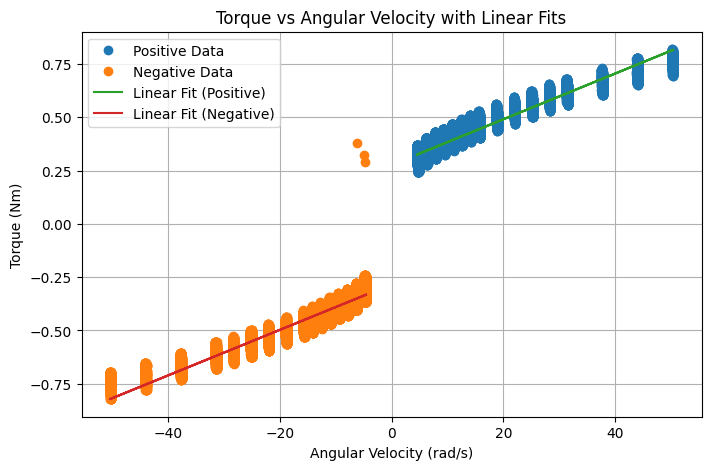

In [460]:
# Extract positive and negative angular velocity and torque from dataframes
positive_w = []
positive_torque = []
negative_w = []
negative_torque = []

for key, df in dataframes.items():
    if df.empty:
        continue
    # Positive side: Angular_Velocity > 0
    pos_mask = df['Angular_Velocity'] > 0
    positive_w.extend(df.loc[pos_mask, 'Angular_Velocity'])
    positive_torque.extend(df.loc[pos_mask, 'Torque_Nm'])
    # Negative side: Angular_Velocity < 0
    neg_mask = df['Angular_Velocity'] < 0
    negative_w.extend(df.loc[neg_mask, 'Angular_Velocity'])
    negative_torque.extend(df.loc[neg_mask, 'Torque_Nm'])

# Linear fit for positive side
fit_pos = np.polyfit(positive_w, positive_torque, 1)
fit_line_pos = np.polyval(fit_pos, positive_w)

# Linear fit for negative side
fit_neg = np.polyfit(negative_w, negative_torque, 1)
fit_line_neg = np.polyval(fit_neg, negative_w)

print(f"Positive fit: slope = {fit_pos[0]:.5f}, intercept = {fit_pos[1]:.5f}")
print(f"Negative fit: slope = {fit_neg[0]:.5f}, intercept = {fit_neg[1]:.5f}")

# Plot data and fit lines
plt.figure(figsize=(8, 5))
plt.plot(positive_w, positive_torque, 'o', label='Positive Data')
plt.plot(negative_w, negative_torque, 'o', label='Negative Data')
plt.plot(positive_w, fit_line_pos, '-', label='Linear Fit (Positive)')
plt.plot(negative_w, fit_line_neg, '-', label='Linear Fit (Negative)')
plt.xlabel('Angular Velocity (rad/s)')
plt.ylabel('Torque (Nm)')
plt.title('Torque vs Angular Velocity with Linear Fits')
plt.legend()
plt.grid(True)
plt.show()

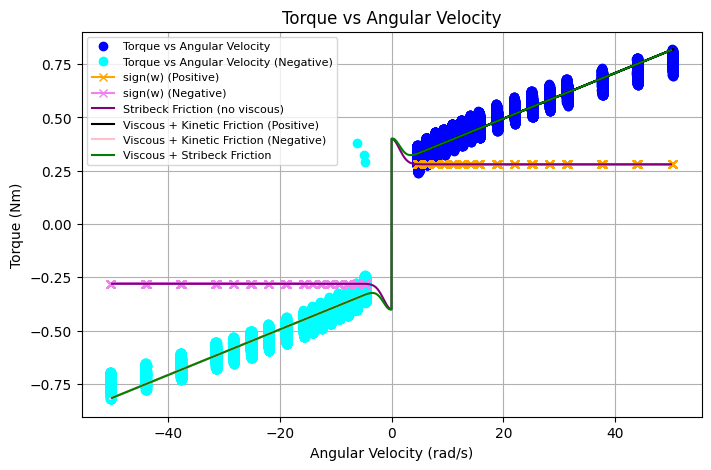

In [461]:
# Calculate sign of angular velocities
sign_pos = np.sign(positive_w)
sign_neg = np.sign(negative_w)
total_angular_velocity = positive_w + negative_w
total_angular_velocity.sort()

# Calculate torque using y-intercepts and sign(w)
torque_yint_pos = [0.28 * s for s in sign_pos]
torque_yint_neg = [0.28 * s for s in sign_neg]

import numpy as np

def stribeck_no_viscous(omega, Ts, Tc, vs, p=2, smooth=True, eps=1e-3):
    """
    Stribeck friction torque without viscous term.

    Parameters
    ----------
    omega : float or np.ndarray
        Angular velocity (rad/s).
    Ts : float
        Static (breakaway) friction torque amplitude.
    Tc : float
        Coulomb (kinetic) friction torque amplitude.
    vs : float
        Stribeck characteristic velocity (rad/s).
    p : int or float, optional
        Shape exponent of the decay (default=2).
    smooth : bool, optional
        Use smooth sign (tanh) if True, else hard sign (default=True).
    eps : float, optional
        Smoothing width for tanh sign (ignored if smooth=False).

    Returns
    -------
    T : float or np.ndarray
        Friction torque.
    """
    g = Tc + (Ts - Tc) * np.exp(- (np.abs(omega) / vs) ** p)
    if smooth:
        s = np.tanh(omega / eps)
    else:
        s = np.sign(omega)
    return g * s

# Parameters
Ts = 0.4  # Nm (static friction)
Tc = 0.28 # Nm (Coulomb friction)
vs = 2 # rad/s (Stribeck velocity)

# Angular velocity sweep
# omega_vals = np.array(total_angular_velocity)
omega_vals = np.linspace(-50, 50, 10000)  # rad/s

# Compute friction
T_vals = stribeck_no_viscous(omega_vals, Ts, Tc, vs, p=2, smooth=True)

# T sign(w) model with kinetic friction
viscous_torque_pos = []
viscous_torque_neg = []

# Viscous + Kinetic Friction
for w in positive_w:
    viscous_torque_pos.append(0.28 * np.sign(w) + 0.010705*w)
for w in negative_w:
    viscous_torque_neg.append(0.28 * np.sign(w) + 0.010705*w)

# Viscous + Stribeck friction
viscous_stribeck_torque = []
for w in omega_vals:
    viscous_stribeck_torque.append(stribeck_no_viscous(w, Ts, Tc, vs, p=2, smooth=True) + 0.010705*w)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(positive_w, positive_torque, 'o', label='Torque vs Angular Velocity', color = 'blue')
plt.plot(negative_w, negative_torque, 'o', label='Torque vs Angular Velocity (Negative)', color = 'cyan')
plt.plot(positive_w, torque_yint_pos, 'x-', label='sign(w) (Positive)', color = 'orange')
plt.plot(negative_w, torque_yint_neg, 'x-', label='sign(w) (Negative)', color = 'violet')
plt.plot(omega_vals, T_vals, label='Stribeck Friction (no viscous)', color='purple')
plt.plot(positive_w, viscous_torque_pos, label = 'Viscous + Kinetic Friction (Positive)', color='black')
plt.plot(negative_w, viscous_torque_neg, label = 'Viscous + Kinetic Friction (Negative)', color='pink')
plt.plot(omega_vals, viscous_stribeck_torque, label='Viscous + Stribeck Friction', color='green')

plt.xlabel('Angular Velocity (rad/s)')
plt.ylabel('Torque (Nm)')
plt.title('Torque vs Angular Velocity')
plt.grid(True)
plt.legend(fontsize = 8)
plt.show()

# PART B

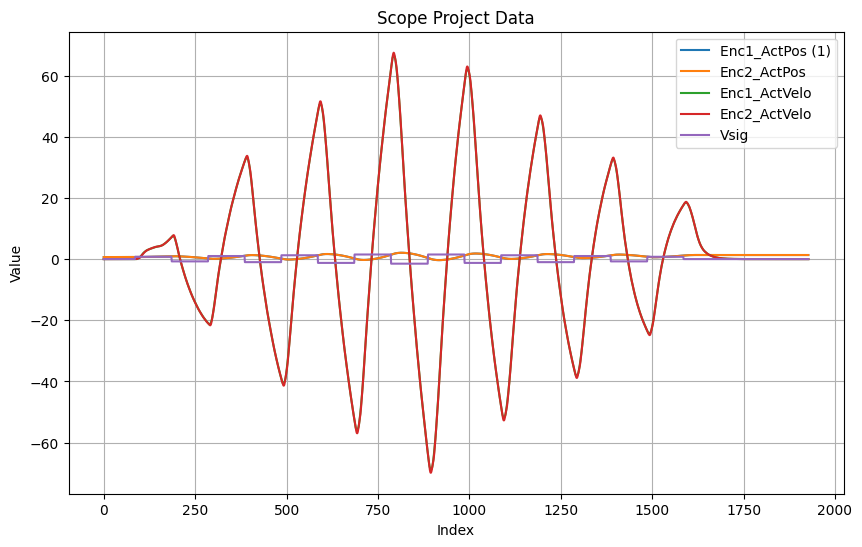

In [462]:
# Load the CSV file, skipping the first 8 rows
scope_df = pd.read_csv('C:\\Users\\kylea\\Repos\\MECH_467_Labs\\Lab1\\Data\\part b\\Scope Project.csv', skiprows=8)
# Remove rows with NaN values
scope_df = scope_df.dropna()
# Plot all columns
scope_df.plot(figsize=(10, 6), title='Scope Project Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [463]:
scope_df

,Name,Enc1_ActPos (1),Enc2_ActPos,Enc1_ActVelo,Enc2_ActVelo,Vsig
0,0,0.6563,0.6581,0.000000,0.000000,0.0
1,0.5,0.6563,0.6581,0.000000,0.000000,0.0
2,1,0.6563,0.6581,0.000000,0.000000,0.0
3,1.5,0.6563,0.6581,0.000000,0.000000,0.0
4,2,0.6563,0.6581,0.000000,0.000000,0.0
...,...,...,...,...,...,...
1923,961.5,1.3271,1.3291,0.000813,-0.000027,0.0
1924,962,1.3271,1.3291,0.000774,-0.000025,0.0
1925,962.5,1.3271,1.3291,0.000738,-0.000024,0.0
1926,963,1.3271,1.3291,0.000702,-0.000023,0.0


0.1
[0.0004166 0.0016664 0.0024996 0.0016664 0.0004166][ 1.         -3.18063855  3.86119435 -2.11215536  0.43826514]
[0.20618272 0.20618272 0.20618272 ... 0.41695145 0.41695184 0.41695218]


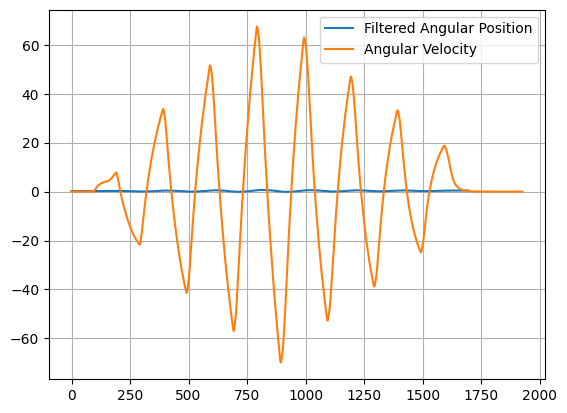

In [464]:
# Filter 
from scipy.signal import butter, filtfilt

# Example values
Ts = 0.5/1000       # sampling period (s) -> fs = 1/Ts
fs = 1 / Ts       # sampling frequency
fc = 100         # cutoff frequency (Hz)

df['Angular_Position'] = (2 * math.pi * scope_df['Enc1_ActPos (1)']) / pitch

# Design 4th-order Butterworth low-pass filter
Wn = fc / (fs / 2)   # normalize cutoff to Nyquist frequency
print(Wn)
# Wn = 2*100*Ts
b, a = butter(4, Wn, btype='low')
print(str(b) + "" + str(a))
# Apply zero-phase filtering
theta_filt = filtfilt(b, a, df['Angular_Position'])
# theta_filt -= 0.6563

valid_mask = ~np.isnan(theta_filt)

print(theta_filt)
plt.plot(theta_filt, label = "Filtered Angular Position")
plt.plot(scope_df['Enc2_ActVelo'], label = "Angular Velocity")
plt.legend()
plt.grid(True)


(1698,)
(1698,)


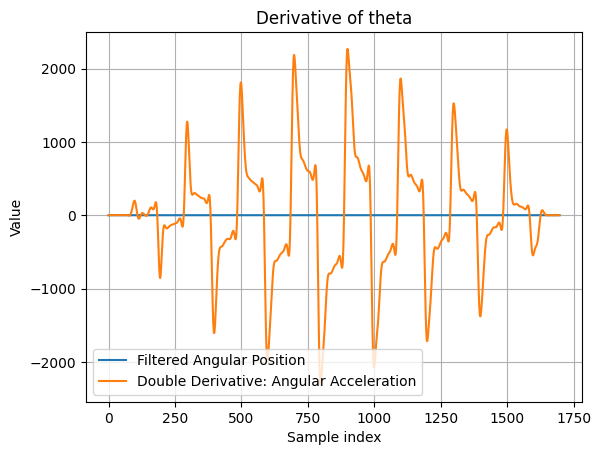

In [490]:
# Carry out the derivativ
from deriv import deriv
print(theta_filt.shape)
omega = deriv(theta_filt, Ts)
print(omega[0].shape)
omega_dot = deriv(omega[0], Ts)
derived_measured_angular_acc = deriv(scope_df['Enc2_ActVelo'], Ts)

plt.plot(theta_filt, label="Filtered Angular Position")
#plt.plot(derived_measured_angular_acc[0], label="Derived Measured Angular Acceleration")
plt.plot(omega_dot[0], label="Double Derivative: Angular Acceleration")
plt.title("Derivative of theta")
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()  


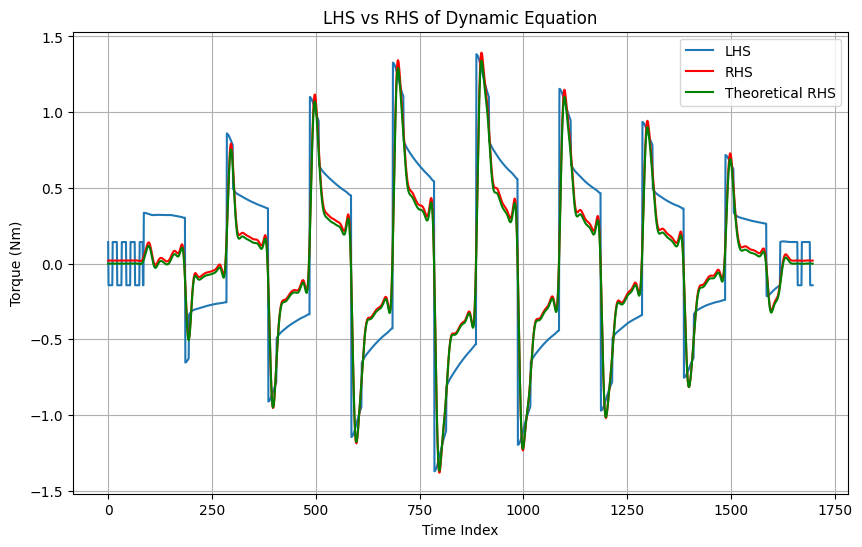

In [501]:
# Graph both LHS and RHS of dynamic Equation
# constants
# --- Common parameters ---
J = 5.904e-4
B = 0.006
K_t = 0.72
S_g = 0.887
B_e = 0.010705
mew_k = 0.0933
J_e = 6.05e-4
T_d = 0.14
mew_k = 0.1427

# omega_aligned = theta_filt[valid_mask]
# vsig_aligned = scope_df['Vsig'][valid_mask].reset_index(drop=True)

valid_indices = np.where(valid_mask)[0]
vsig_aligned = scope_df['Vsig'].iloc[valid_indices].reset_index(drop=True)

# Viscous + Stribeck friction
viscous_stribeck_torque = []
for w in omega[0]:
    viscous_stribeck_torque.append(stribeck_no_viscous(w, Ts, Tc, vs, p=2, smooth=True) + 0.00804*w)

LHS = (S_g * K_t * vsig_aligned) - (B_e * omega[0]) - mew_k*np.sign(omega[0])
RHS = J_e * omega_dot[0] + 0.02
Theoretical = J * omega_dot[0]

plt.figure(figsize=(10, 6))
plt.plot(LHS, label='LHS')
plt.plot(RHS, label='RHS', color = 'red')
plt.plot(Theoretical, label='Theoretical RHS', color = "green")
plt.title('LHS vs RHS of Dynamic Equation')
plt.xlabel('Time Index')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.show()